# EE 527 Machine Learning Lab
## Course Project  
-----------------------------------------
214161006 Pathak Sanchit Vivekanand

214161011 Sushovan Saha

# Collaborative Filtering (Recommendation System)


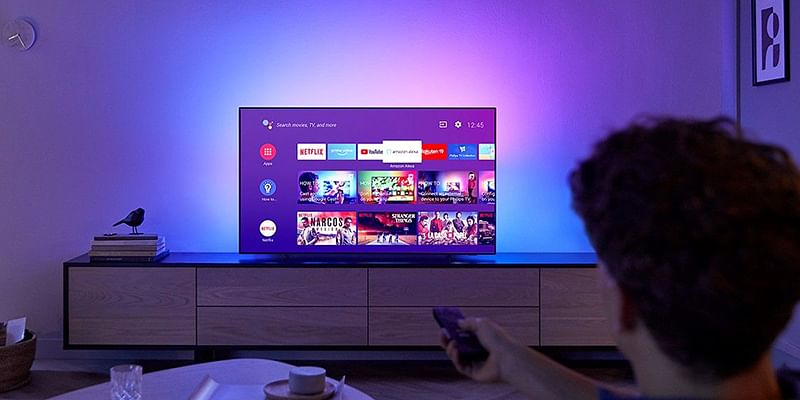


Collaborative filtering is the most common way to do product recommendation online. It’s “collaborative” because it predicts a given customers preferences on the basis of other customers.

* Collaborative filtering technique works by building a database (user-item matrix) of preferences for items by users.
* It then matches users with relevant interest and preferences by calculating similarities between their profiles to make recommendations.
* An user gets recommendations to those items that he has not rated before but that were already positively rated by users in his neighborhood.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse.linalg import svds
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate

import recmetrics

import warnings
warnings.filterwarnings('ignore')

## Dataset - MovieLens 1M

Link - https://grouplens.org/datasets/movielens/1m/

## Read Dataset

In [2]:
reviews = pd.read_csv('ml-1m/ratings.dat', names=['userId', 'movieId', 'rating', 'time'], delimiter='::', engine='python',encoding="ISO-8859-1")
movies = pd.read_csv('ml-1m/movies.dat', names=['movieId', 'movie_names', 'genres'], delimiter='::', engine='python',encoding="ISO-8859-1")
users = pd.read_csv('ml-1m/users.dat', names=['userId', 'gender', 'age', 'occupation', 'zip'], delimiter='::', engine='python',encoding="ISO-8859-1")

print('Reviews shape:', reviews.shape)
print('Users shape:', users.shape)
print('Movies shape:', movies.shape)

Reviews shape: (1000209, 4)
Users shape: (6040, 5)
Movies shape: (3883, 3)


In [3]:
reviews.head()

,userId,movieId,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
users.head()

,userId,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [5]:
movies.head()

,movieId,movie_names,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Check if all values from 1 to 3883 form the movieIds or not

In [6]:
(movies['movieId']==[i+1 for i in range(0,movies.shape[0])]).sum()

90

In [7]:
movies['movieId'].max()

3952

So movieIds are 1 to 3952 with 90 numbers skipped

### Drop unwanted columns

timestamps and zipcode are not required, hence dropped

In [8]:
reviews.drop(['time'], axis=1, inplace=True)
users.drop(['zip'], axis=1, inplace=True)

In [9]:
movies['release_year'] = movies['movie_names'].str.extract(r'(?:\((\d{4})\))?\s*$', expand=False)

In [10]:
movies.head()

,movieId,movie_names,genres,release_year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


## Visualization of Data

The taggings for age, occupation and gender is provided here: https://files.grouplens.org/datasets/movielens/ml-1m-README.txt

We can visualize the types of users that participated in this survey/dataset

In [11]:
#define maps for age categories, occupations
ages_map = {1: '< 18',
            18: '18 - 24',
            25: '25 - 34',
            35: '35 - 44',
            45: '45 - 49',
            50: '50 - 55',
            56: '56+'}

occupations_map = {0: 'Others',
                   1: 'Academic/Educator',
                   2: 'Artist',
                   3: 'Clerical/Admin',
                   4: 'College/Grad Student',
                   5: 'Customer Service',
                   6: 'Doctor/Health Care',
                   7: 'Executive/Managerial',
                   8: 'Farmer',
                   9: 'Homemaker',
                   10: 'K-12 student',
                   11: 'Lawyer',
                   12: 'Programmer',
                   13: 'Retired',
                   14: 'Sales/Marketing',
                   15: 'Scientist',
                   16: 'Self-Employed',
                   17: 'Technician/Engineer',
                   18: 'Tradesman/Craftsman',
                   19: 'Unemployed',
                   20: 'Writer'}

gender_map = {'M': 'Male', 'F': 'Female'}

users['age'] = users['age'].map(ages_map)
users['occupation'] = users['occupation'].map(occupations_map)
users['gender'] = users['gender'].map(gender_map)

## Merge all dfs into a common df as reviews+movies+users

In [12]:
df = reviews.merge(movies, on='movieId', how='left').merge(users, on='userId', how='left')

print('merged df shape:', df.shape)

merged df shape: (1000209, 9)


In [13]:
df.head()

,userId,movieId,rating,movie_names,genres,release_year,gender,age,occupation
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,1975,Female,< 18,K-12 student
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,1996,Female,< 18,K-12 student
2,1,914,3,My Fair Lady (1964),Musical|Romance,1964,Female,< 18,K-12 student
3,1,3408,4,Erin Brockovich (2000),Drama,2000,Female,< 18,K-12 student
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,Female,< 18,K-12 student


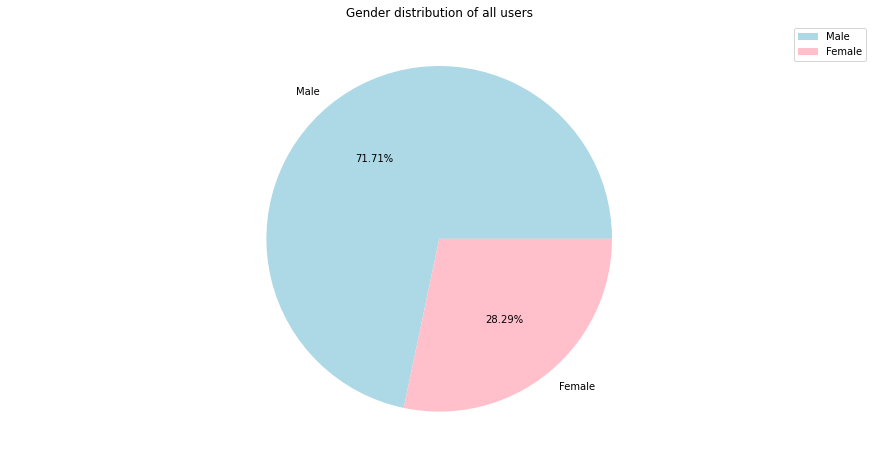

In [14]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(users['gender'].value_counts().values, labels = users['gender'].value_counts().index,autopct='%1.2f%%', colors=['lightblue','pink'])
plt.legend()
plt.title("Gender distribution of all users")
plt.show()

#### Almost 72% of users are male, rest are female

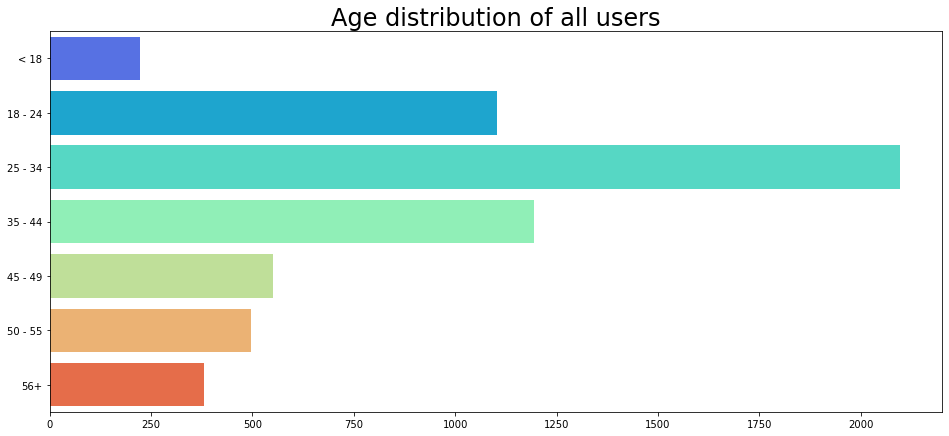

In [15]:
#define labels in the order we want
age_reindex = ['< 18', '18 - 24', '25 - 34', '35 - 44', '45 - 49', '50 - 55', '56+']
#count the number of users wrt their ages - this will return a Data Series...reindex it with our defined order
age_counts = users['age'].value_counts().reindex(age_reindex)

plt.figure(figsize=(16,7))
sns.barplot(x=age_counts.values,
            y=age_counts.index,
            palette='rainbow').set_title('Age distribution of all users', fontsize=24)

plt.show()

#### Majority of users are 25 to 34 years in age

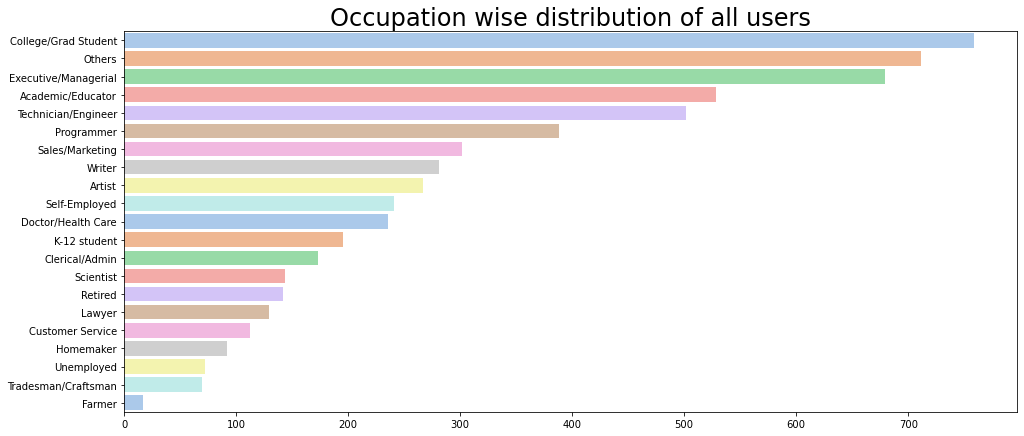

In [16]:
#count users wrt occupations and sort in descending order for a good barchart
occup_counts = users['occupation'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(16,7))
sns.barplot(x=occup_counts.values,
            y=occup_counts.index,
            palette='pastel').set_title('Occupation wise distribution of all users', fontsize=24)

plt.show()

# Singular Value Decomposition (SVD) of Rating-User Matrix

The Singular Value Decomposition (SVD), a method from linear algebra that has been generally used as a dimensionality reduction technique in machine learning. SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K<N). In the context of the recommender system, the SVD is used as a collaborative filtering technique.

<h1><center>$A = U \Sigma V^{T}$

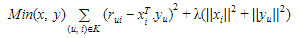

In [17]:
print('Number of users:', df['userId'].nunique())
print('Number of movies:', df['movieId'].nunique())

Number of users: 6040
Number of movies: 3706


### Make rating-user matrix (ru_matrix) and fill NaN values with 0 (NaN = movie not rated by user)

In [18]:
#make a pivot table of user vs movie with elements as ratings
ru_matrix = df.pivot(index='userId',columns='movieId',values='rating')
ru_matrix = ru_matrix.fillna(0)
ru_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#find mean movie-wise
mean = np.mean(ru_matrix.values, axis=1)
ratings_new = ru_matrix.values - mean.reshape(-1, 1)

U, sigma, Vt = svds(ratings_new, k=100)

sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + mean.reshape(-1, 1)
preds = pd.DataFrame(predicted_ratings, columns = ru_matrix.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,5.157608,0.184833,0.348341,-0.022609,0.139622,-0.156937,-0.061122,0.072117,0.018278,-0.372566,...,-0.111771,-0.002460,0.016625,-0.107081,-0.051609,0.022706,-0.114028,0.009476,0.070798,-0.195959
1,0.557186,0.296927,0.078853,-0.013888,0.028675,1.092160,-0.054492,0.114191,0.090106,1.695371,...,0.002564,-0.022910,-0.031687,0.072002,-0.008174,-0.418219,-0.225593,-0.005716,0.033955,0.039606
2,2.176318,0.396428,0.302057,-0.117164,-0.006330,0.077833,0.000836,0.064654,-0.018309,1.062417,...,0.036894,-0.008054,0.026507,0.053735,0.025591,0.024825,0.169800,0.061687,0.028985,-0.243151
3,0.194185,0.155507,0.046863,0.047477,-0.014495,0.247765,-0.057580,-0.006338,0.007387,-0.423240,...,-0.049155,-0.010652,0.007342,-0.005267,-0.031352,-0.166973,0.022989,-0.033161,-0.011156,-0.129075
4,0.243474,-0.491501,-0.008307,0.139973,-0.204174,1.664607,-0.133342,-0.047117,-0.118995,0.129404,...,0.054157,0.065400,0.004748,-0.072018,-0.106567,-0.590538,0.219853,-0.062958,0.105441,0.009634


In [20]:
def recommend_movies(preds, userID, movies, reviews, n_recom):
    
    #Get and sort the user's predictions
    user_idx = userID - 1 
    user_predicted_ratings = preds.iloc[user_idx,:].sort_values(ascending=False)
    
    #Get the user's data and merge in the movie information
    user_data = reviews[reviews["userId"] == (userID)]
    user_rated_movies = user_data.merge(movies, how = 'left', on = 'movieId')#.sort_values(['rating'], ascending=False)

    print('The User {0} has already rated {1} movies'.format(userID, user_rated_movies.shape[0]))
    print('Suggesting top {} recommended movies not seen by the user'.format(n_recom))
    
    #Recommend the highest predicted rating movies that the user has not seen yet
    user_recommended_movies = (movies[~movies['movieId'].isin(user_rated_movies['movieId'])].
         merge(pd.DataFrame(user_predicted_ratings).reset_index(), how = 'left', left_on = 'movieId',right_on = 'movieId').
         rename(columns = {user_idx: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:n_recom, :-1])

    return user_rated_movies, user_recommended_movies

In [21]:
user_already_rated, recommend = recommend_movies(preds, 1900, movies, reviews, 10)

The User 1900 has already rated 40 movies
Suggesting top 10 recommended movies not seen by the user


### Movies user 1900 has already rated

In [22]:
user_already_rated

,userId,movieId,rating,movie_names,genres,release_year
0,1900,2987,4,Who Framed Roger Rabbit? (1988),Adventure|Animation|Film-Noir,1988
1,1900,2069,4,"Trip to Bountiful, The (1985)",Drama,1985
2,1900,913,5,"Maltese Falcon, The (1941)",Film-Noir|Mystery,1941
3,1900,3053,3,"Messenger: The Story of Joan of Arc, The (1999)",Drama|War,1999
4,1900,920,4,Gone with the Wind (1939),Drama|Romance|War,1939
5,1900,2607,5,Get Real (1998),Drama,1998
6,1900,3298,4,Boiler Room (2000),Drama,2000
7,1900,3606,4,On the Town (1949),Musical,1949
8,1900,2826,2,"13th Warrior, The (1999)",Action|Horror|Thriller,1999
9,1900,2827,3,"Astronaut's Wife, The (1999)",Sci-Fi|Thriller,1999


### Top n_recom movies that user 1900 hopefully will enjoy

In [23]:
recommend

,movieId,movie_names,genres,release_year
2256,2336,Elizabeth (1998),Drama,1998
2627,2716,Ghostbusters (1984),Comedy|Horror,1984
3072,3176,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,1999
1936,2013,"Poseidon Adventure, The (1972)",Action|Adventure,1972
2351,2433,"Civil Action, A (1998)",Drama,1998
2678,2770,Bowfinger (1999),Comedy,1999
2671,2763,"Thomas Crown Affair, The (1999)",Action|Thriller,1999
2288,2369,Desperately Seeking Susan (1985),Comedy|Romance,1985
3302,3408,Erin Brockovich (2000),Drama,2000
2516,2598,Pushing Tin (1999),Comedy,1999


## Evaluation Metrics using Surprise library

For evaluation, we need to create train and test set for which we will be using surprise library

In [24]:
data = Dataset.load_builtin('ml-1m')
algo = SVD()

#Run 5-fold cross-validation
dict_result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Test RMSE: {}".format(dict_result['test_rmse']))
print("Test MAE: {}".format(dict_result['test_mae']))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8711  0.8735  0.8755  0.8739  0.8750  0.8738  0.0015  
MAE (testset)     0.6837  0.6851  0.6876  0.6857  0.6874  0.6859  0.0015  
Fit time          29.27   29.69   29.79   28.89   29.25   29.38   0.33    
Test time         1.16    1.51    1.48    1.28    1.56    1.40    0.15    
Test RMSE: [0.87112816 0.87345096 0.87549065 0.8739459  0.87497628]
Test MAE: [0.68373586 0.68508335 0.68758055 0.68574985 0.68743095]


### Plot of k-fold cross validation

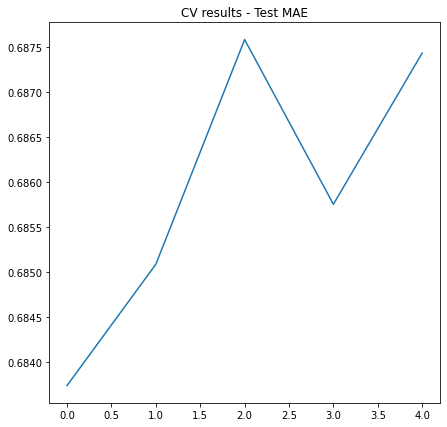

In [25]:
plt.figure(figsize=(7,7))
plt.plot(range(5),dict_result['test_mae'])
plt.title("CV results - Test MAE")
plt.show()

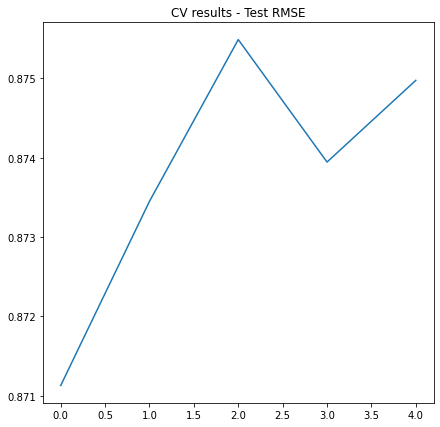

In [26]:
plt.figure(figsize=(7,7))
plt.plot(range(5),dict_result['test_rmse'])
plt.title("CV results - Test RMSE")
plt.show()

### Long Tail Plot
Tail Plot is used to explore popularity patterns in user-item interaction data such as clicks, ratings, or purchases. Typically, only a small percentage of movies have a high volume of interactions, and this is referred to as the “head”. Most movies are in the “long tail”.

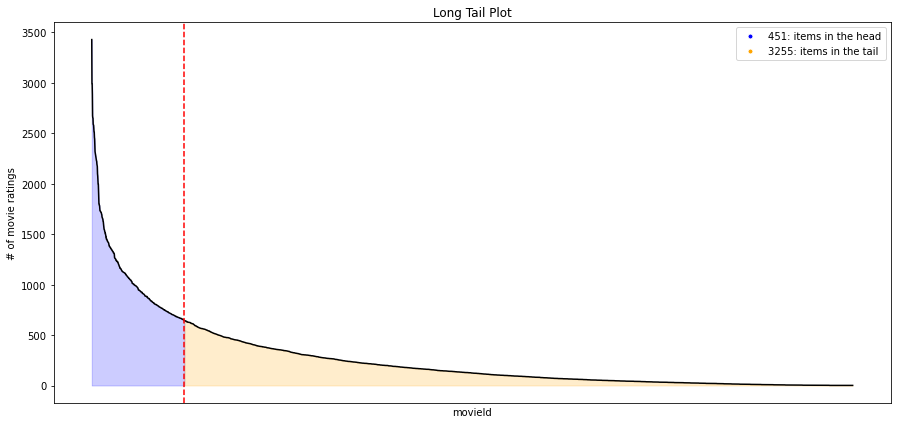

In [27]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=reviews, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

### RMSE & MSE using recmetrics library on train-test sets

We repeat the above experiment using a different library - recmetrics 

In [28]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(reviews[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2,random_state = 42)

In [29]:
algo = SVD()
algo.fit(trainset)

In [30]:
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,1841,3717,1.0,1.996980
1,3715,880,3.0,2.245342
2,2002,3072,4.0,3.960185
3,3332,2734,3.0,3.498054
4,3576,631,3.0,2.472798


In [31]:
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.7642965927905595
RMSE:  0.8742405806130024


The lesser the RMSE and MSE values, better the model.


# Thank You!